## Required imports ##

In [1]:
import zfit
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import iminuit
import mplhep as hep
from scipy.integrate import quad
plt.style.use(hep.style.LHCb2)

/Users/kp14102/miniforge3/envs/hep-env/lib/python3.11/site-packages/zfit/__init__.py:68: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


## The expression below gives the cross section of the processes $e^{+}e^{-}\rightarrow  \mu^+\mu^-$, via a $Z^0$ boson, as a function of the centre of mass energy $\sqrt{s}$ and the mass and width of the $Z$ boson ($m_{Z}$, $\Gamma_{Z}$) ##

$$\sigma(e^{+}e^{-}\rightarrow  \mu^+\mu^-) = \frac{12\pi s}{m_{Z}^{2}}\frac{\Gamma_{ee}\Gamma_{\mu\mu}}{(s-m_{Z}^{2})^{2}+m_{Z}^{2}\Gamma_{Z}^{2}}$$

# Question 1 #

- What are the assumptions that go into the expression above?
- What is the physical meaning of $\Gamma_{ee}$ and $\Gamma_{\mu\mu}$?

## A Python function that returns a numerical value of the aforementioned cross-section $\sigma(e^{+}e^{-}\rightarrow  \mu^+\mu^-)$ is shown below: ##

In [2]:
def sigma_ee_mm(x,mZ,gZ,gee,gmm):
    s = x*x
    mZsq = mZ**2
    sigma = np.pi*s*gee*gmm/(mZsq*(s-mZsq)**2+mZsq*gZ**2)
    return sigma

## The snippet below plots the cross section as a function of $\sqrt{s}$ ## 

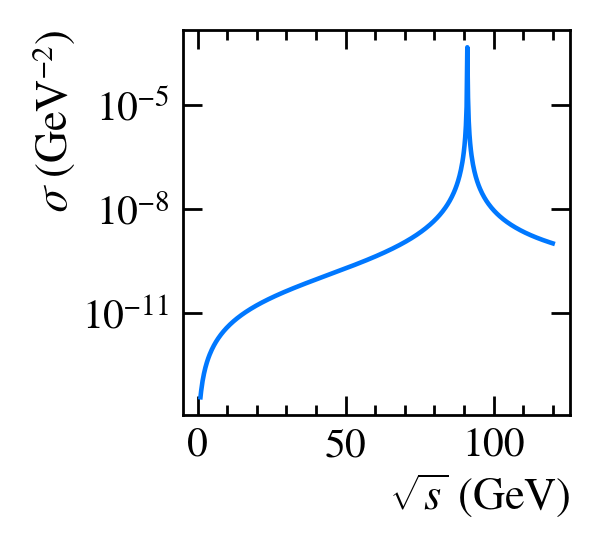

In [17]:
mZ, gZ = 91.18, 2.496 # in GeV 
gee, gmm = 0.084, 0.084 # in GeV
sqrts = np.linspace(1,120,500)
xsec = sigma_ee_mm(sqrts,mZ,gZ,gee,gmm)
plt.figure(figsize=(5,5)) 
plt.tight_layout()
plt.yscale('log')
plt.plot(sqrts,xsec)
plt.xlabel("$\sqrt{s}$ (GeV)")
plt.ylabel("$\sigma$ ($\mathrm{GeV}^{-2})$")
plt.show()

# Question 2 #
- Explain how we arrived at the values of the parameters "gee" and "gmm" given in the cell above
- The plot above shows the cross-section drop at around 1GeV. Is this effect physical? Explain your reasoning. 

# Question 3 #
- Which parameter would you modify in the expression of the cross section given above in order to describe the process $e^+e^- \to\mathrm{hadrons}$?
- Describe a step-by-step approach to determining the number of generations of neutrinos
    - You are given the measured values of $\sigma_{ee\to\mathrm{hadrons}}$ at a few $\sqrt{s}$ points (TODO)
    - You should use the expression of $\sigma_{ee\to\mathrm{hadrons}}$ 

## The cell below show an example of how to generate some data according to the cross-section function shown above and plot a histogram of the generated values 

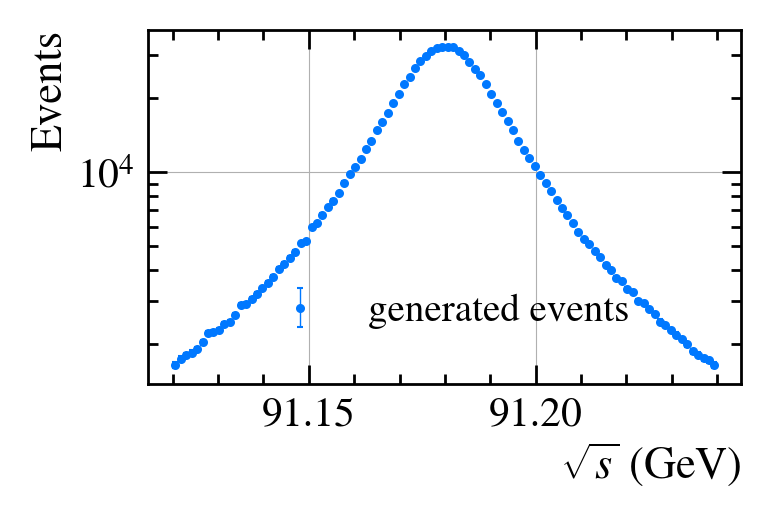

In [37]:
from scipy.integrate import quad, quad_vec
from scipy.interpolate import interp1d
def gen_data(n_events,sigma_ee_mm,sqrts_min,sqrts_max,mZ,gZ,gee,gmm):
    """
    Generate cross section as a function of energy using the CDF method
    """   
    # Step 1: Create finely spaced energy grid
    npoints=1000000    
    sqrts_grid = np.linspace(sqrts_min, sqrts_max, npoints)
    sigma_vals = np.array([sigma_ee_mm(sqrts,mZ,gZ,gee,gmm) for sqrts in sqrts_grid])

    # Step 2: Create cumulative distribution function (CDF)
    cumulative = np.cumsum(sigma_vals)
    cumulative /= cumulative[-1]  # Normalize to [0,1]

    # Invert CDF
    inv_cdf = interp1d(cumulative, sqrts_grid, bounds_error=False, fill_value=(sqrts_min, sqrts_max))

    # Step 3: Sample from the inverted CDF
    random_probs = np.random.rand(n_events)
    sampled_energies = inv_cdf(random_probs)

    return sampled_energies


# Generate 1000000 values of sqrts according to the expression of the cross-section function defined
# earlier for CoM energies between sqrts_min and sqrts_max
sqrts_min = 91.12
sqrts_max = 91.24
n_events = 1000000
sqrts_vals = gen_data(n_events,sigma_ee_mm,sqrts_min,sqrts_max,mZ,gZ,gee,gmm)

# Plot a histogram of the data we just generated
hist, bin_edges = np.histogram(sqrts_vals, bins=100)
errors = np.sqrt(hist)

fig, ax = plt.subplots(figsize=(8,5))
hep.histplot(hist,bins=bin_edges,
    histtype="errorbar",yerr=errors,
    label="generated events",
    color="C0",ax=ax
)
ax.set_xlabel("$\sqrt{s}$ (GeV)")
ax.set_ylabel("Events")
ax.legend()
fig.tight_layout()
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

## The cell below shows an example of how to create a cumulative distribution probability density function of the cross-section function and feed it to a minimisation algorithm together with the generated data to determine $\Gamma_Z$


In [39]:

''' 
Imports required for the likelihood minimisation algorithm that we will use to fit the
generated data in the above cell in order to determine gZ
'''
# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the Binned Log Likelihood function
from iminuit.cost import BinnedNLL

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)

'''
The function below defines the cumulative distribution function of the cross-section expression
that we will feed into the minimisation algorithm
'''
def sigma_ee_mm_cdf(bin_edges,mZ, gZ, gee, gmm):
    xmin, xmax = bin_edges[0], bin_edges[-1]

    def indef_integr(xx, mZ, gZ, gee, gmm):
        val, _ = quad(sigma_ee_mm, xmin, xx, args=(mZ, gZ, gee, gmm))
        return val

    norm = indef_integr(xmax, mZ, gZ, gee, gmm)

    # evaluate for each bin edge
    integr = np.array([indef_integr(xx, mZ, gZ, gee, gmm) for xx in np.atleast_1d(bin_edges)])
    return (integr - indef_integr(xmin, mZ, gZ, gee, gmm)) / norm

'''
The minimisation algorithm takes in the `toy` data we created in the previous cell, along with
the cdf function defined above and performs a fit to estimate the Z width gZ using a so-called
binned negative log-likelihood cost function
'''
cost = BinnedNLL(hist, bin_edges, sigma_ee_mm_cdf)
# Initialises the minimisation algorithm and takes starting values of the parameters we are fitting for
m = Minuit(cost, mZ=91,gZ=2,gee=0.084,gmm=0.084) 
m.fixed['gee']=True  # we only want to determine mZ, gZ so keep gee fixed to its actual value
m.fixed['gmm']=True  # we only want to determine mZ, gZ so keep gmm fixed to its actual value

m.migrad()  # finds minimum of binned negative log likelihood function
m.hesse()   # accurately computes uncertainties

iminuit version: 2.31.1


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 77.09 (χ²/ndof = 0.8)      │              Nfcn = 140              │
│ EDM = 5.07e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mZ   │ 91.179998 │ 0.000018  │            │            │         │         │       │
│ 1 │ gZ   │   2.499   │   0.004   │            │            │         │         │       │
│ 2 │ gee  │  84.0e-3  │  0.8e-3   │            │            │         │         │  yes  │
│ 3 │ gmm  │  84.0e-3  │  0.8e-3   │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────┐
│     │       mZ       gZ      gee      gmm │
├─────┼─────────────────────────────────────┤
│  mZ │ 3.28e-10  0.09e-9        0        0 │
│  gZ │  0.09e-9 1.56e-05        0        0 │
│ gee │        0        0        0        0 │
│ gmm │        0        0        0        0 │
└─────┴─────────────────────────────────────┘